In [26]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import NMF

In [27]:
sentences = [
    'seven triple six triple four triple',
    'one double three double five six seven',
    'seven two triple six triple five triple',
    'seven four three double five double',
    'seven two double six double four',
    'seven double four five double six three',
    'seven triple six triple five triple'
]

In [28]:
counter = CountVectorizer()

counts = counter.fit_transform(sentences)

In [29]:
words = counter.get_feature_names()
counts = pd.DataFrame(counts.todense(),columns=words)
counts

,double,five,four,one,seven,six,three,triple,two
0,0,0,1,0,1,1,0,3,0
1,2,1,0,1,1,1,1,0,0
2,0,1,0,0,1,1,0,3,1
3,2,1,1,0,1,0,1,0,0
4,2,0,1,0,1,1,0,0,1
5,2,1,1,0,1,1,1,0,0
6,0,1,0,0,1,1,0,3,0


In [30]:
dfcf = pd.DataFrame(index=words)

In [31]:
#get df, cf
dfcf['df'] = counts.astype(bool).sum(axis=0)
dfcf['cf'] = counts.sum(axis=0)
dfcf['idf'] = np.log2(7/dfcf.df)



In [32]:
dfcf = pd.concat([counts.T,dfcf],axis=1)
dfcf

,0,1,2,3,4,5,6,df,cf,idf
double,0,2,0,2,2,2,0,4,8,0.807355
five,0,1,1,1,0,1,1,5,5,0.485427
four,1,0,0,1,1,1,0,4,4,0.807355
one,0,1,0,0,0,0,0,1,1,2.807355
seven,1,1,1,1,1,1,1,7,7,0.000000
six,1,1,1,0,1,1,1,6,6,0.222392
three,0,1,0,1,0,1,0,3,3,1.222392
triple,3,0,3,0,0,0,3,3,9,1.222392
two,0,0,1,0,1,0,0,2,2,1.807355


In [33]:
plotdf = dfcf.sort_values(by='idf',ascending=False)

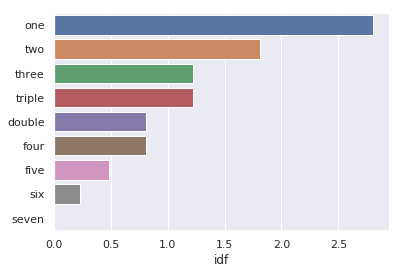

In [34]:
sns.barplot(plotdf.idf,plotdf.index)
plt.show()

In [35]:
sent_col = [i for i in range(0,7)]
for col in dfcf.iloc[:, :7]:
    dfcf['tfidf'+str(col)] = round(dfcf[col] * dfcf.idf,4)


In [36]:
dfcf

,0,1,2,3,4,5,6,df,cf,idf,tfidf0,tfidf1,tfidf2,tfidf3,tfidf4,tfidf5,tfidf6
double,0,2,0,2,2,2,0,4,8,0.807355,0.0000,1.6147,0.0000,1.6147,1.6147,1.6147,0.0000
five,0,1,1,1,0,1,1,5,5,0.485427,0.0000,0.4854,0.4854,0.4854,0.0000,0.4854,0.4854
four,1,0,0,1,1,1,0,4,4,0.807355,0.8074,0.0000,0.0000,0.8074,0.8074,0.8074,0.0000
one,0,1,0,0,0,0,0,1,1,2.807355,0.0000,2.8074,0.0000,0.0000,0.0000,0.0000,0.0000
seven,1,1,1,1,1,1,1,7,7,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
six,1,1,1,0,1,1,1,6,6,0.222392,0.2224,0.2224,0.2224,0.0000,0.2224,0.2224,0.2224
three,0,1,0,1,0,1,0,3,3,1.222392,0.0000,1.2224,0.0000,1.2224,0.0000,1.2224,0.0000
triple,3,0,3,0,0,0,3,3,9,1.222392,3.6672,0.0000,3.6672,0.0000,0.0000,0.0000,3.6672
two,0,0,1,0,1,0,0,2,2,1.807355,0.0000,0.0000,1.8074,0.0000,1.8074,0.0000,0.0000


In [37]:
vectorizer = TfidfVectorizer()
sent_tfidf = vectorizer.fit_transform(sentences)

pd.DataFrame(sent_tfidf.todense().T)

,0,1,2,3,4,5,6
0,0.000000,0.639316,0.000000,0.727550,0.712781,0.700512,0.000000
1,0.000000,0.280012,0.221924,0.318657,0.000000,0.306814,0.236108
2,0.267289,0.000000,0.000000,0.363775,0.356391,0.350256,0.000000
3,0.000000,0.518909,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.181829,0.217454,0.172344,0.247465,0.242442,0.238269,0.183359
5,0.206108,0.246491,0.195357,0.000000,0.274816,0.270085,0.207843
6,0.000000,0.368182,0.000000,0.418995,0.000000,0.403424,0.000000
7,0.923588,0.000000,0.875409,0.000000,0.000000,0.000000,0.931361
8,0.000000,0.000000,0.341383,0.000000,0.480236,0.000000,0.000000


In [38]:
names = vectorizer.get_feature_names()

In [39]:
ntopics = 2
n_top_words = 5

def word_topic(tfidf,solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str) 
        topwords.loc[column]=chosenlist
    return(topwords)

In [40]:
ntopics = 7
nmf = NMF(alpha=0.0, 
      init='nndsvdar', # how starting value are calculated
      l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
      max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
      n_components=ntopics, 
      random_state=0, 
      solver='cd', # Use Coordinate Descent to solve
      tol=0.0001, # model will stop if tfidf-WH <= tol
      verbose=0 # amount of output to give while iterating
     )


In [41]:
topwords = pd.DataFrame()

In [42]:
sent_nmf = nmf.fit_transform(sent_tfidf) 
comps_nmf = word_topic(sent_tfidf, sent_nmf, names)
topwords['NNMF']=top_words(comps_nmf, n_top_words)


In [43]:
pd.DataFrame(sent_nmf)

,0,1,2,3,4,5,6
0,0.000000,7.784884e-01,0.000000,0.000000e+00,0.000000e+00,0.280879,0.323250
1,0.434684,4.609052e-09,0.000000,6.052710e-01,5.022731e-08,0.000106,0.000000
2,0.000000,7.421237e-01,0.005151,0.000000e+00,7.479337e-01,0.124097,0.000000
3,0.622275,0.000000e+00,0.002166,0.000000e+00,0.000000e+00,0.000000,0.438702
4,0.000019,0.000000e+00,1.080258,7.095308e-07,0.000000e+00,0.000028,0.000476
5,0.598998,0.000000e+00,0.002471,1.004754e-05,0.000000e+00,0.580267,0.422242
6,0.029761,8.040484e-01,0.000000,0.000000e+00,1.026004e-01,0.260275,0.000000


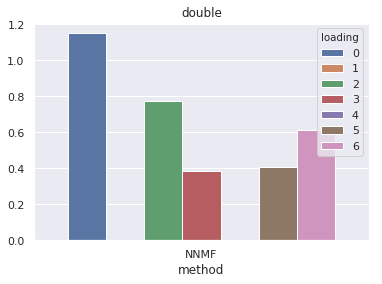

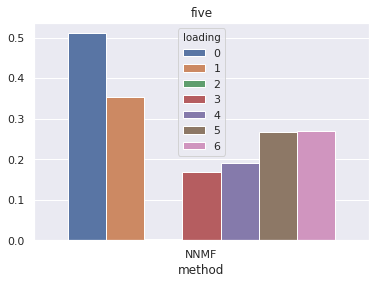

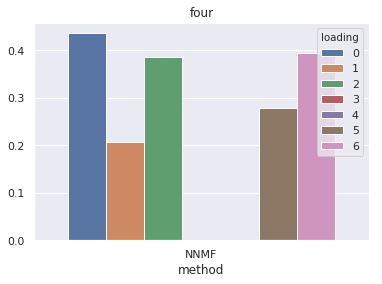

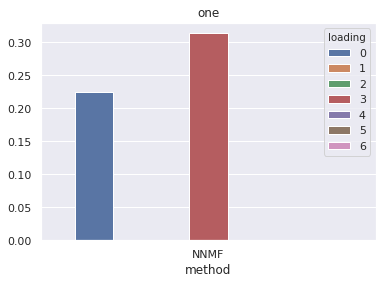

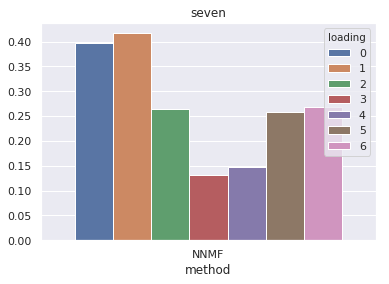

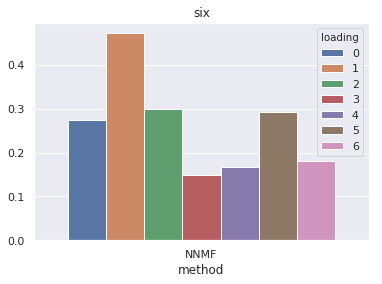

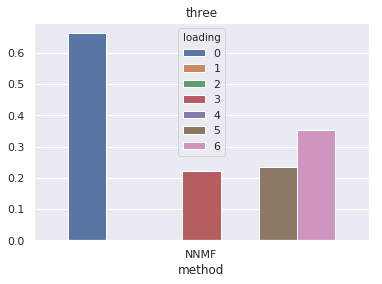

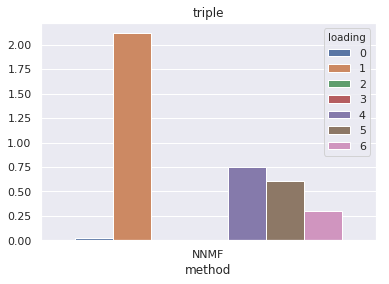

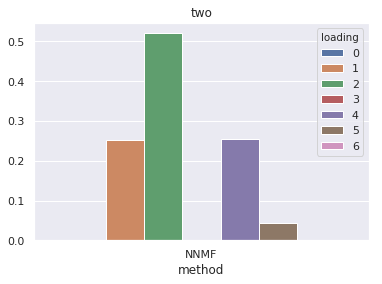

In [44]:


wordloadings=pd.DataFrame(columns=words)

for word in words:
    loadings=comps_nmf.loc[word]
    wordloadings[word]=loadings
    
# Labeling the data by method and providing an ordering variable for graphing purposes. 
wordloadings['method']=np.repeat(['NNMF'], 7, axis=0)
wordloadings['loading']=[0,1,2,3,4,5,6]

sns.set(style="darkgrid")

for word in words:
    sns.barplot(x="method", y=word, hue="loading", data=wordloadings)
    plt.title(word)
    plt.ylabel("")
    plt.show()